## The Pacific region named Niño 3.4 (5N-5S, 170W-120W) is used to define the Sea Surface Temperatures (SST) anomalies that defines a el Niño event. Moreover, the Oceanic Niño Index (ONI) is calculated based on the data of this region.  

## Taking this information into account, in this project we are going to focus in the study of that region and discard all other points. 


### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Check the data

In [2]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


### We plot the observations that are contain in the interest region (5N-5S, 170W-120W). We increase 0.5 the latitude for each side to include all observations that are set at around 5. 

In [5]:
oni_region = data[(data['latitude'] < 5.5) & (data['latitude'] > -5.5) & (data['longitude'] > -170) & (data['longitude'] < -120)]

In [6]:
oni_region.shape

(50608, 12)

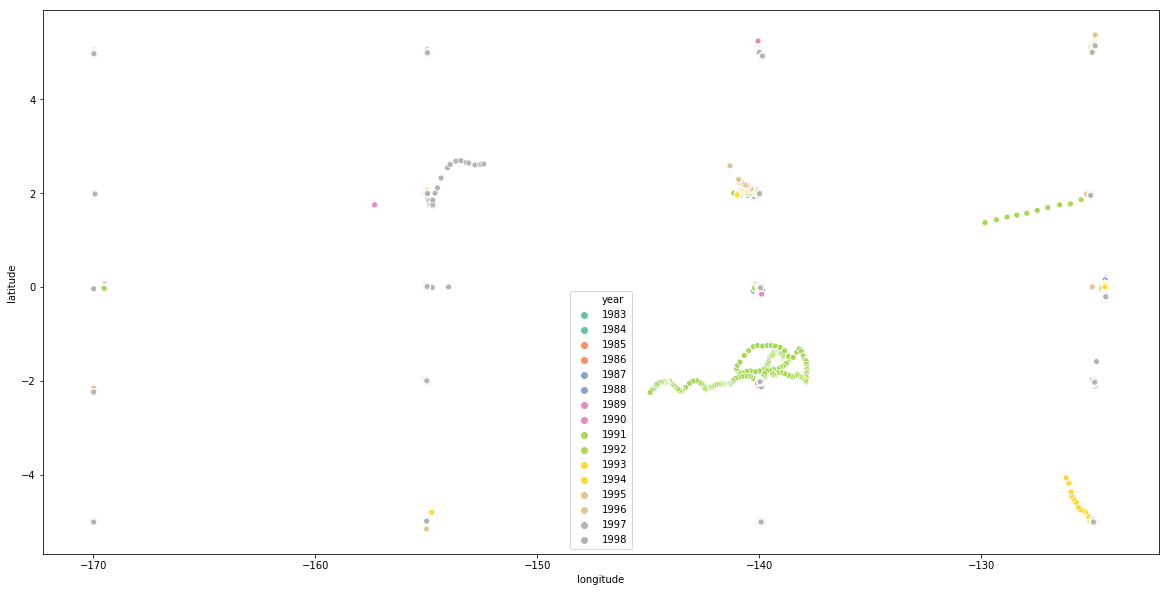

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=oni_region['longitude'], y=oni_region['latitude'], hue=oni_region['year'],legend= 'full', palette='Set2' )

### We use DBSCAN method from sklearn to cluster our observations. Each cluster will correspond to one different buoy.

#### We will cluster the observations in base of their location and year. Thus, we define X with the longitude and latitude.

In [8]:
X = oni_region[['latitude', 'longitude']]

#### We set the most important parameters for DBSCAN

In [9]:
eps = 2.2
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples = 200
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [10]:
dbs = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs.fit(X)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "sklearn/cluster/_dbscan_inner.pyx", line 14, in sklearn.cluster._dbscan_inner.push
  File "sklearn/cluster/_dbscan_inner.pyx", line 14, in sklearn.cluster._dbscan_inner.push
  File "sklearn/cluster/_dbscan_inner.pyx", line 14, in sklearn.cluster._dbscan_inner.push
  [Previous line repeated 555856 more times]
MemoryError: std::bad_alloc

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/atwenter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-07dcfd1b323a>", line 2, in <module>
    dbs.fit(X)
  File "/home/atwenter/anaconda3/lib/python3.7/site-packages/sklearn/cluster/dbscan_.py", line 321, in fit
    **self.get_params())
  File "/home/atwenter/anaconda3/lib/python3.7/site-packages/sklearn/cluster/dbscan_.py", line 175, in dbscan
    dbscan_inner(core

SystemError: <built-in function dbscan_inner> returned a result with an error set

#### We evaluate the model using the Silhouette score.

In [132]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
# silhouette_score(X, dbs.labels_, sample_size= 50000)

#### We add the labels from DBSCAN to a new column in the dataset.

In [133]:
oni_region['buoy_label'] = dbs.labels_

In [134]:
len(oni_region['buoy_label'].unique())

14

In [135]:
oni_region['buoy_label'].value_counts().tail()

 4     2006
 9     1953
 3     1721
 12     998
-1        9
Name: buoy_label, dtype: int64

In [136]:
oni_region['buoy_label'].value_counts().head()

1     12391
0      9003
2      7011
6      3308
10     2791
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

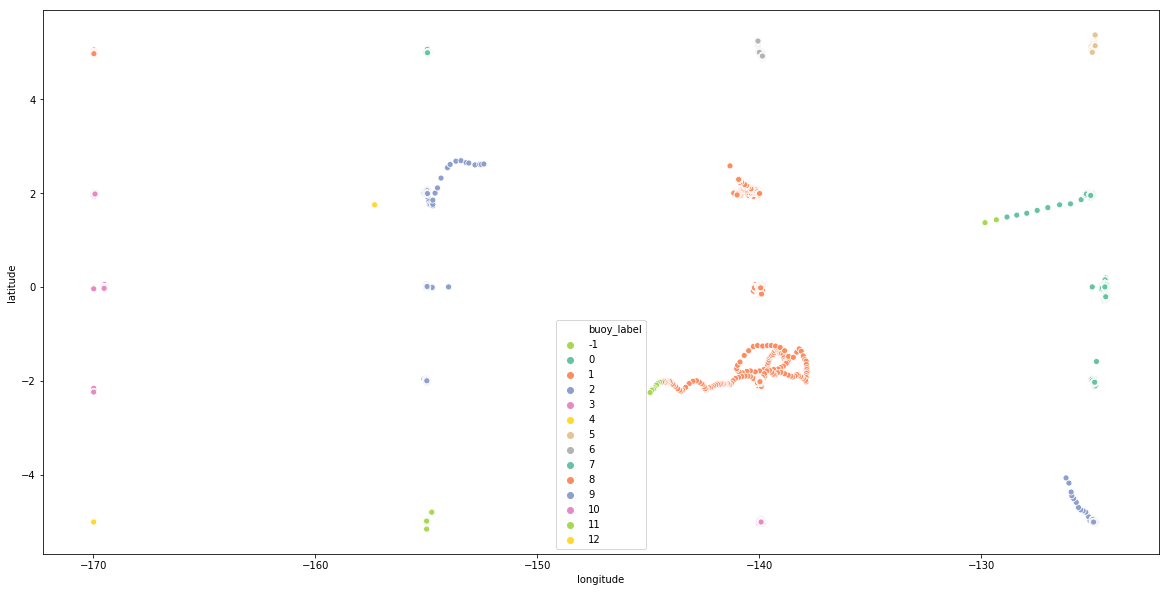

In [137]:
location = oni_region[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

### We save our results in a .csv

In [138]:
oni_region.to_csv('../Data/Oni_region_label.csv', index= False)